In [1]:
from datetime import datetime
import time,pytz
import os, glob, subprocess, sys, uuid
from tqdm import tqdm

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["PYTHONHASHSEED"] = "42"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "1"
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

import keras

import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

GLOBAL_RANDOM_SEED = 42

random.seed(GLOBAL_RANDOM_SEED)
np.random.seed(GLOBAL_RANDOM_SEED)
tf.random.set_seed(GLOBAL_RANDOM_SEED)
tf.config.experimental.enable_op_determinism()
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
initializer = keras.initializers.GlorotUniform(seed=GLOBAL_RANDOM_SEED)

2025-09-14 11:28:49.755628: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757836729.775144  102913 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757836729.781082  102913 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-14 11:28:57.037916: E tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:55] The TF_FORCE_GPU_ALLOW_GROWTH environment variable is set but could not be parsed: "1". Valid values are "true" or "false". Using original config value of 1.
I0000 00:00:1757836737.038970  102913 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5223 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Lapto

In [2]:
# ========== LOAD & CLEAN ==========
column_names = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"
]

files = [
    ("data/processed.cleveland.data", "cleveland"),
    ("data/processed.hungarian.data", "hungarian"),
    ("data/processed.switzerland.data", "switzerland"),
    ("data/processed.va.data", "va")
]

# Load data with source tracking
dfs = []
for file_path, source in files:
    temp_df = pd.read_csv(file_path, names=column_names, na_values='?', header=None)
    temp_df['source'] = source
    dfs.append(temp_df)

df = pd.concat(dfs, ignore_index=True)

# Convert columns to numeric, binarize target
for col in column_names:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

print(df.describe())

              age         sex          cp    trestbps        chol         fbs  \
count  920.000000  920.000000  920.000000  861.000000  890.000000  830.000000   
mean    53.510870    0.789130    3.250000  132.132404  199.130337    0.166265   
std      9.424685    0.408148    0.930969   19.066070  110.780810    0.372543   
min     28.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
25%     47.000000    1.000000    3.000000  120.000000  175.000000    0.000000   
50%     54.000000    1.000000    4.000000  130.000000  223.000000    0.000000   
75%     60.000000    1.000000    4.000000  140.000000  268.000000    0.000000   
max     77.000000    1.000000    4.000000  200.000000  603.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  918.000000  865.000000  865.000000  858.000000  611.000000  309.000000   
mean     0.604575  137.545665    0.389595    0.878788    1.770867    0.676375   
std      0.805827   25.9262

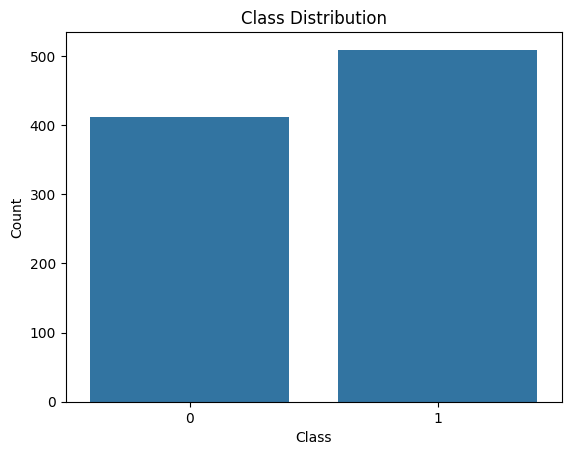

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='target', data=df)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [4]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from skrebate import ReliefF
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from scipy.stats import randint, uniform
import seaborn as sns
from sklearn.ensemble import VotingClassifier, StackingClassifier

# ========== IMPUTATION ==========
dfs_imputed = []
for source in df['source'].unique():
    temp = df[df['source'] == source].copy()
    numeric_cols = temp.select_dtypes(include=[np.number]).columns.drop('target')
    imputer = KNNImputer(n_neighbors=min(5, len(temp)-1))
    temp[numeric_cols] = imputer.fit_transform(temp[numeric_cols])
    dfs_imputed.append(temp)

df = pd.concat(dfs_imputed, ignore_index=True)
df = pd.get_dummies(df, columns=['source'], prefix='src')
df = df.fillna(df.median())

# ========== SPLIT ==========
X = df.drop('target', axis=1)
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=GLOBAL_RANDOM_SEED
)

# ========== VOTING & STACKING CLASSIFIERS ==========
base_learners = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier()),
    ('svm', SVC(probability=True)),
    ('knn', KNeighborsClassifier()),
    ('xgb', XGBClassifier(eval_metric='logloss'))
]

voting_clf = VotingClassifier(
    estimators=base_learners,
    voting='soft',      # average predicted probabilities
    n_jobs=-1
)

stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(),
    passthrough=True,   # pass original features plus base predictions to final layer
    cv=5,
    n_jobs=-1
)

# ========== MODELS & SELECTORS ==========
models = {
    "LogReg": LogisticRegression(max_iter=1000),
    "DecTree": DecisionTreeClassifier(),
    "RandForest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
    "Voting": voting_clf,
    "Stacking": stacking_clf
}

selectors = {
    "None": [],  # <-- baseline, no feature selection
    "Chi2": [("nonneg_shift", FunctionTransformer(lambda x: x - x.min(axis=0))), ("select", SelectKBest(chi2, k=10))],
    "MutInfo": [("select", SelectKBest(mutual_info_classif, k=9))],
    "ReliefF": [("select", ReliefF(n_features_to_select=9))],
    "PCA": [("reduce", PCA(n_components=10))]
}

# ========== HYPERPARAMETER TUNING SETUP ==========
param_grids = {
    "LogReg": {
        "model__C": uniform(0.1, 10),
        "model__penalty": ['l2', None],
        "model__solver": ['newton-cg', 'lbfgs', 'sag']
    },
    "DecTree": {
        "model__max_depth": [None, 5, 10, 15, 20, 25],
        "model__min_samples_split": randint(2, 20),
        "model__min_samples_leaf": randint(1, 10),
        "model__max_features": ['sqrt', 'log2', None]
    },
    "RandForest": {
        "model__n_estimators": [100, 200, 300],
        "model__max_depth": [None, 10, 20, 30],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4],
        "model__max_features": ['sqrt', 'log2']
    },
    "SVM": {
        "model__C": uniform(0.1, 10),
        "model__kernel": ['linear', 'rbf', 'poly'],
        "model__gamma": ['scale']
    },
    "KNN": {
        "model__n_neighbors": randint(3, 15),
        "model__weights": ['uniform', 'distance'],
        "model__p": [1, 2]  # 1: manhattan, 2: euclidean
    },
    "XGBoost": {
        "model__n_estimators": [100, 200, 300],
        "model__max_depth": [3, 6, 9],
        "model__learning_rate": [0.01, 0.05, 0.1],
        "model__subsample": [0.8, 0.9, 1.0],
        "model__colsample_bytree": [0.8, 0.9, 1.0]
    }
}

# For ensemble methods
param_grids["Voting"] = {
    "model__weights": [
        [1, 1, 1, 1, 1, 1],  # equal weights
        [1, 1, 2, 1, 1, 2],  # favor RF and XGBoost
        [1, 1, 3, 1, 1, 3]   # strong favor to best performers
    ]
}

# ========== FEATURE EXTRACTION FUNCTION ==========
def get_selected_features(pipe, X_train):
    """
    Extract selected feature names from a pipeline with feature selection steps
    """
    try:
        # Check for feature selection steps
        if "select" in pipe.named_steps:
            sel = pipe.named_steps["select"]
            if hasattr(sel, "get_support"):
                mask = sel.get_support()
                return X_train.columns[mask].tolist()
            if hasattr(sel, "top_features_"):
                idxs = list(sel.top_features_)
                return [X_train.columns[i] for i in idxs]
        
        # Check for dimensionality reduction steps
        if "reduce" in pipe.named_steps:
            pc = pipe.named_steps["reduce"]
            if hasattr(pc, "n_components_"):
                return [f"PC{i+1}" for i in range(pc.n_components_)]
            elif hasattr(pc, "n_components"):
                return [f"PC{i+1}" for i in range(pc.n_components)]
    
    except Exception as e:
        return [f"[Error extracting features: {e}]"]
    
    return ["[No selector to extract from]"]

# ========== MODIFIED PIPELINE WITH TUNING ==========
results = []

for sel_name, sel_steps in selectors.items():
    for model_name, model in models.items():
        print(f"Processing: {sel_name} + {model_name}")
        
        # Skip tuning for Stacking (complex to tune)
        if model_name == "Stacking":
            steps = [("scaler", StandardScaler())] + sel_steps + [("smote", SMOTE(random_state=GLOBAL_RANDOM_SEED)), ("model", model)]
            pipe = ImbPipeline(steps)
            pipe.fit(X_train, y_train)
            
            y_pred = pipe.predict(X_test)
            y_proba = pipe.predict_proba(X_test)[:, 1]
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            auc = roc_auc_score(y_test, y_proba)
            
            # Extract feature names
            if sel_name == "None":
                selected_features = X_train.columns.tolist()
            else:
                selected_features = get_selected_features(pipe, X_train)
            
            results.append({
                "Selector": sel_name,
                "Model": model_name,
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1 Score": f1,
                "AUC": auc,
                "Selected Features": selected_features,
                "Tuned": False,
                "Tuning Info": "No tuning for Stacking"
            })
            continue
            
        # For other models
        steps = [("scaler", StandardScaler())] + sel_steps + [("smote", SMOTE(random_state=GLOBAL_RANDOM_SEED)), ("model", model)]
        pipe = ImbPipeline(steps)
        
        # Check if we have a parameter grid for this model
        if model_name in param_grids:
            print(f"  Tuning {model_name}...")
            
            # Use GridSearchCV for small parameter spaces, RandomizedSearchCV for large ones
            if model_name in ["Voting"]:
                # Use GridSearchCV for small parameter spaces
                search = GridSearchCV(
                    pipe,
                    param_grids[model_name],
                    cv=3,
                    scoring='roc_auc',
                    n_jobs=-1
                )
            else:
                # Use RandomizedSearchCV for larger parameter spaces
                search = RandomizedSearchCV(
                    pipe,
                    param_grids[model_name],
                    n_iter=15,
                    cv=3,
                    scoring='roc_auc',
                    random_state=GLOBAL_RANDOM_SEED,
                    n_jobs=-1,
                    verbose=0
                )
            
            # Perform the search
            search.fit(X_train, y_train)
            
            # Get the best estimator
            best_estimator = search.best_estimator_
            
            # Get predictions
            y_pred = best_estimator.predict(X_test)
            y_proba = best_estimator.predict_proba(X_test)[:, 1]
            
            # Store tuning information
            tuning_info = {
                "best_params": search.best_params_,
                "best_score": search.best_score_
            }
            
            tuned = True
            current_pipe = best_estimator
        else:
            # No tuning grid for this model, use default
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_test)
            y_proba = pipe.predict_proba(X_test)[:, 1]
            tuning_info = {}
            tuned = False
            current_pipe = pipe
        
        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc = roc_auc_score(y_test, y_proba)
        
        # Get selected features
        if sel_name == "None":
            selected_features = X_train.columns.tolist()
        else:
            selected_features = get_selected_features(current_pipe, X_train)
        
        # Store results
        results.append({
            "Selector": sel_name,
            "Model": model_name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1 Score": f1,
            "AUC": auc,
            "Selected Features": selected_features,
            "Tuned": tuned,
            "Tuning Info": tuning_info if tuned else "No tuning performed"
        })

# ========== SUMMARY ==========
df_results = pd.DataFrame(results)
pd.set_option("display.max_colwidth", None)
print(df_results.sort_values(by="AUC", ascending=False).to_string(index=False))

# Save results to CSV
df_results.to_csv("classification_tuning_results.csv", index=False)
print("\nDetailed results saved to 'classification_tuning_results.csv'")

# Display best model for each feature selection method
print("\nBest model for each feature selection method:")
for selector in selectors.keys():
    selector_results = df_results[df_results["Selector"] == selector]
    best_result = selector_results.loc[selector_results["AUC"].idxmax()]
    print(f"{selector}: {best_result['Model']} (AUC: {best_result['AUC']:.4f})")

# Display best overall model
best_overall = df_results.loc[df_results["AUC"].idxmax()]
print(f"\nBest Overall Model: {best_overall['Model']} with {best_overall['Selector']} "
      f"(AUC: {best_overall['AUC']:.4f})")

Processing: None + LogReg
  Tuning LogReg...


/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.py

Processing: None + DecTree
  Tuning DecTree...
Processing: None + RandForest
  Tuning RandForest...
Processing: None + SVM
  Tuning SVM...
Processing: None + KNN
  Tuning KNN...
Processing: None + XGBoost
  Tuning XGBoost...
Processing: None + Voting
  Tuning Voting...
Processing: None + Stacking
Processing: Chi2 + LogReg
  Tuning LogReg...


/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.py

Processing: Chi2 + DecTree
  Tuning DecTree...
Processing: Chi2 + RandForest
  Tuning RandForest...
Processing: Chi2 + SVM
  Tuning SVM...
Processing: Chi2 + KNN
  Tuning KNN...
Processing: Chi2 + XGBoost
  Tuning XGBoost...
Processing: Chi2 + Voting
  Tuning Voting...
Processing: Chi2 + Stacking
Processing: MutInfo + LogReg
  Tuning LogReg...


/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.py

Processing: MutInfo + DecTree
  Tuning DecTree...
Processing: MutInfo + RandForest
  Tuning RandForest...
Processing: MutInfo + SVM
  Tuning SVM...
Processing: MutInfo + KNN
  Tuning KNN...
Processing: MutInfo + XGBoost
  Tuning XGBoost...
Processing: MutInfo + Voting
  Tuning Voting...
Processing: MutInfo + Stacking
Processing: ReliefF + LogReg
  Tuning LogReg...


/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.py

Processing: ReliefF + DecTree
  Tuning DecTree...
Processing: ReliefF + RandForest
  Tuning RandForest...
Processing: ReliefF + SVM
  Tuning SVM...
Processing: ReliefF + KNN
  Tuning KNN...
Processing: ReliefF + XGBoost
  Tuning XGBoost...
Processing: ReliefF + Voting
  Tuning Voting...
Processing: ReliefF + Stacking
Processing: PCA + LogReg
  Tuning LogReg...


/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arash/.py

Processing: PCA + DecTree
  Tuning DecTree...
Processing: PCA + RandForest
  Tuning RandForest...
Processing: PCA + SVM
  Tuning SVM...
Processing: PCA + KNN
  Tuning KNN...
Processing: PCA + XGBoost
  Tuning XGBoost...
Processing: PCA + Voting
  Tuning Voting...
Processing: PCA + Stacking
Selector      Model  Accuracy  Precision   Recall  F1 Score      AUC                                                                                                                             Selected Features  Tuned                                                                                                                                                                                          Tuning Info
 ReliefF    XGBoost  0.864130   0.905263 0.843137  0.873096 0.939981 [exang, cp, ca, thal, oldpeak, src_hungarian, chol, src_cleveland, slope, src_switzerland, src_va, thalach, age, sex, restecg, trestbps, fbs]   True        {'best_params': {'model__subsample': 0.8, 'model__n_estimators': 300,

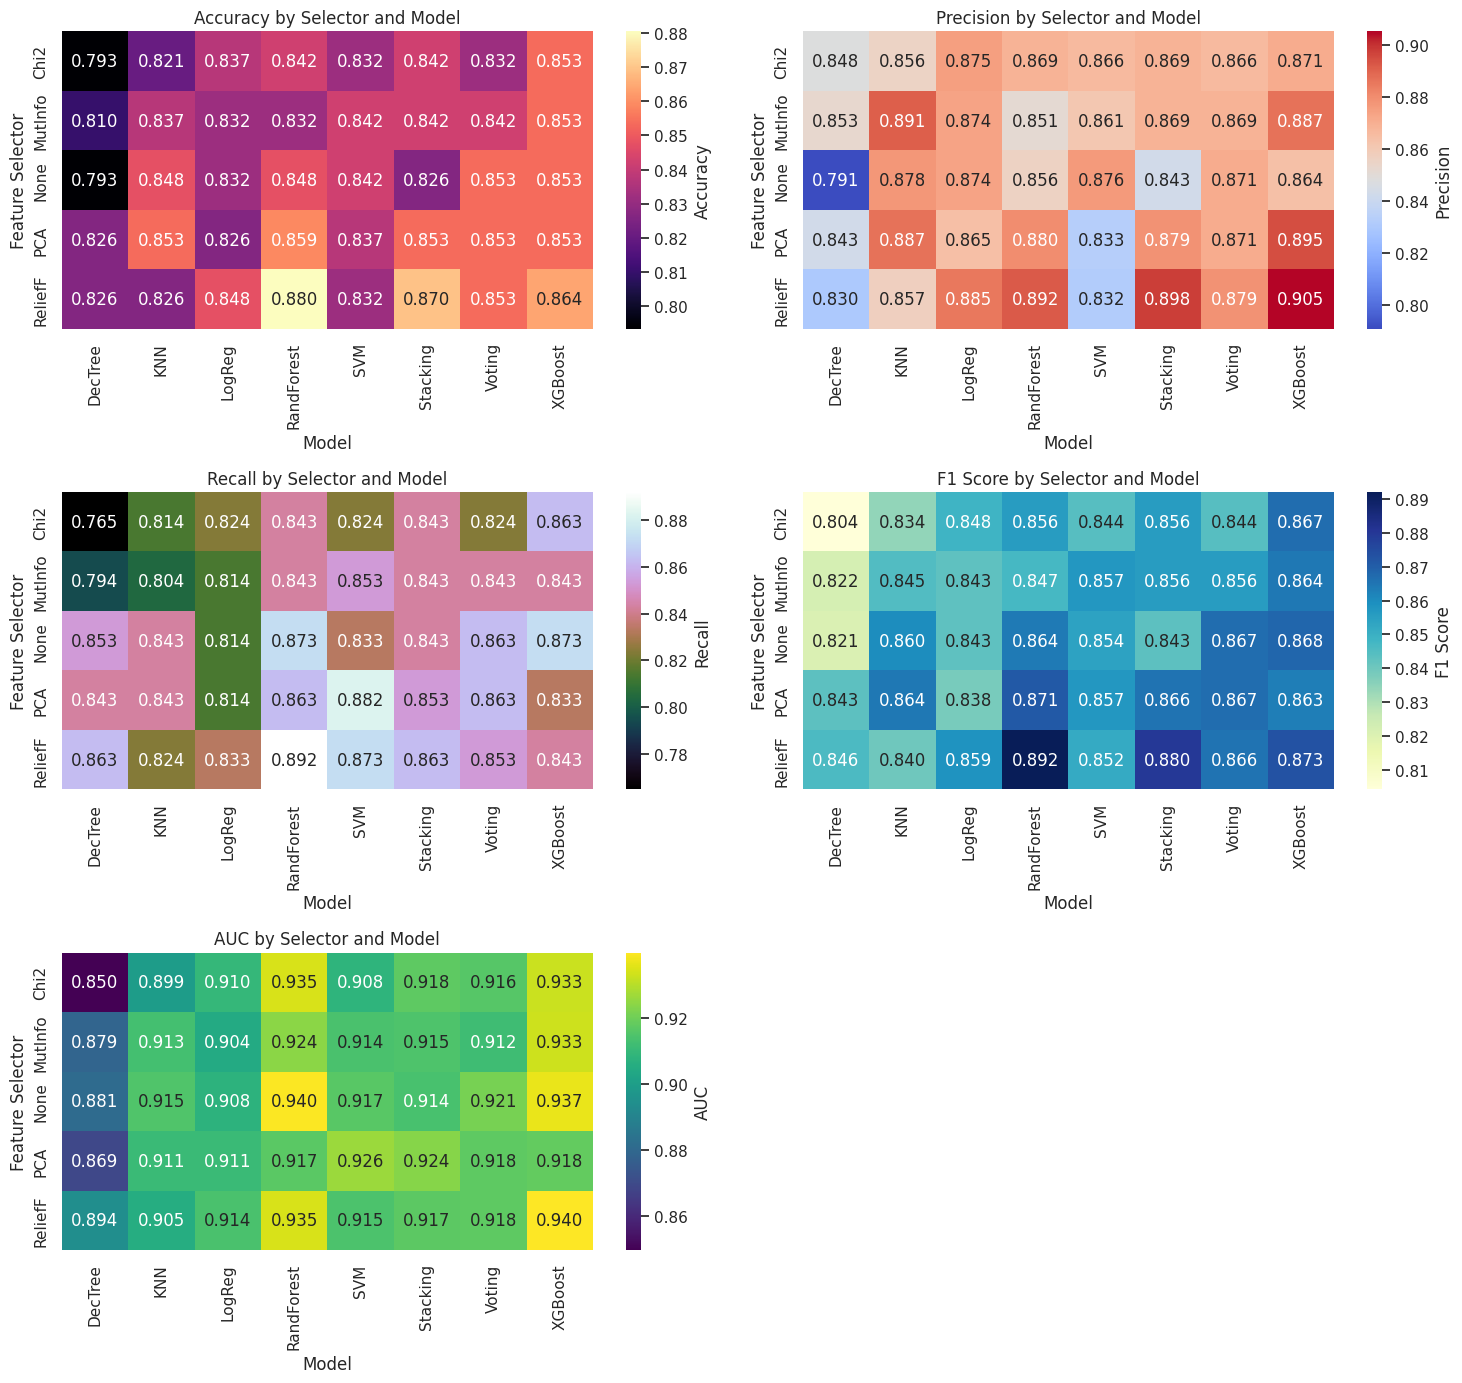

In [5]:
# ========== HITMAPS ==========
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"]
cmap_dict = {
    "Accuracy": "magma",
    "Precision": "coolwarm",
    "Recall": "cubehelix",
    "F1 Score": "YlGnBu",
    "AUC": "viridis"
}

plt.figure(figsize=(15, 14))
sns.set_theme(style="whitegrid")

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    metric_matrix = df_results.pivot(index="Selector", columns="Model", values=metric)
    sns.heatmap(metric_matrix, annot=True, fmt=".3f", cmap=cmap_dict[metric], cbar_kws={'label': metric})
    plt.title(f"{metric} by Selector and Model")
    plt.xlabel("Model")
    plt.ylabel("Feature Selector")

plt.tight_layout()
plt.show()

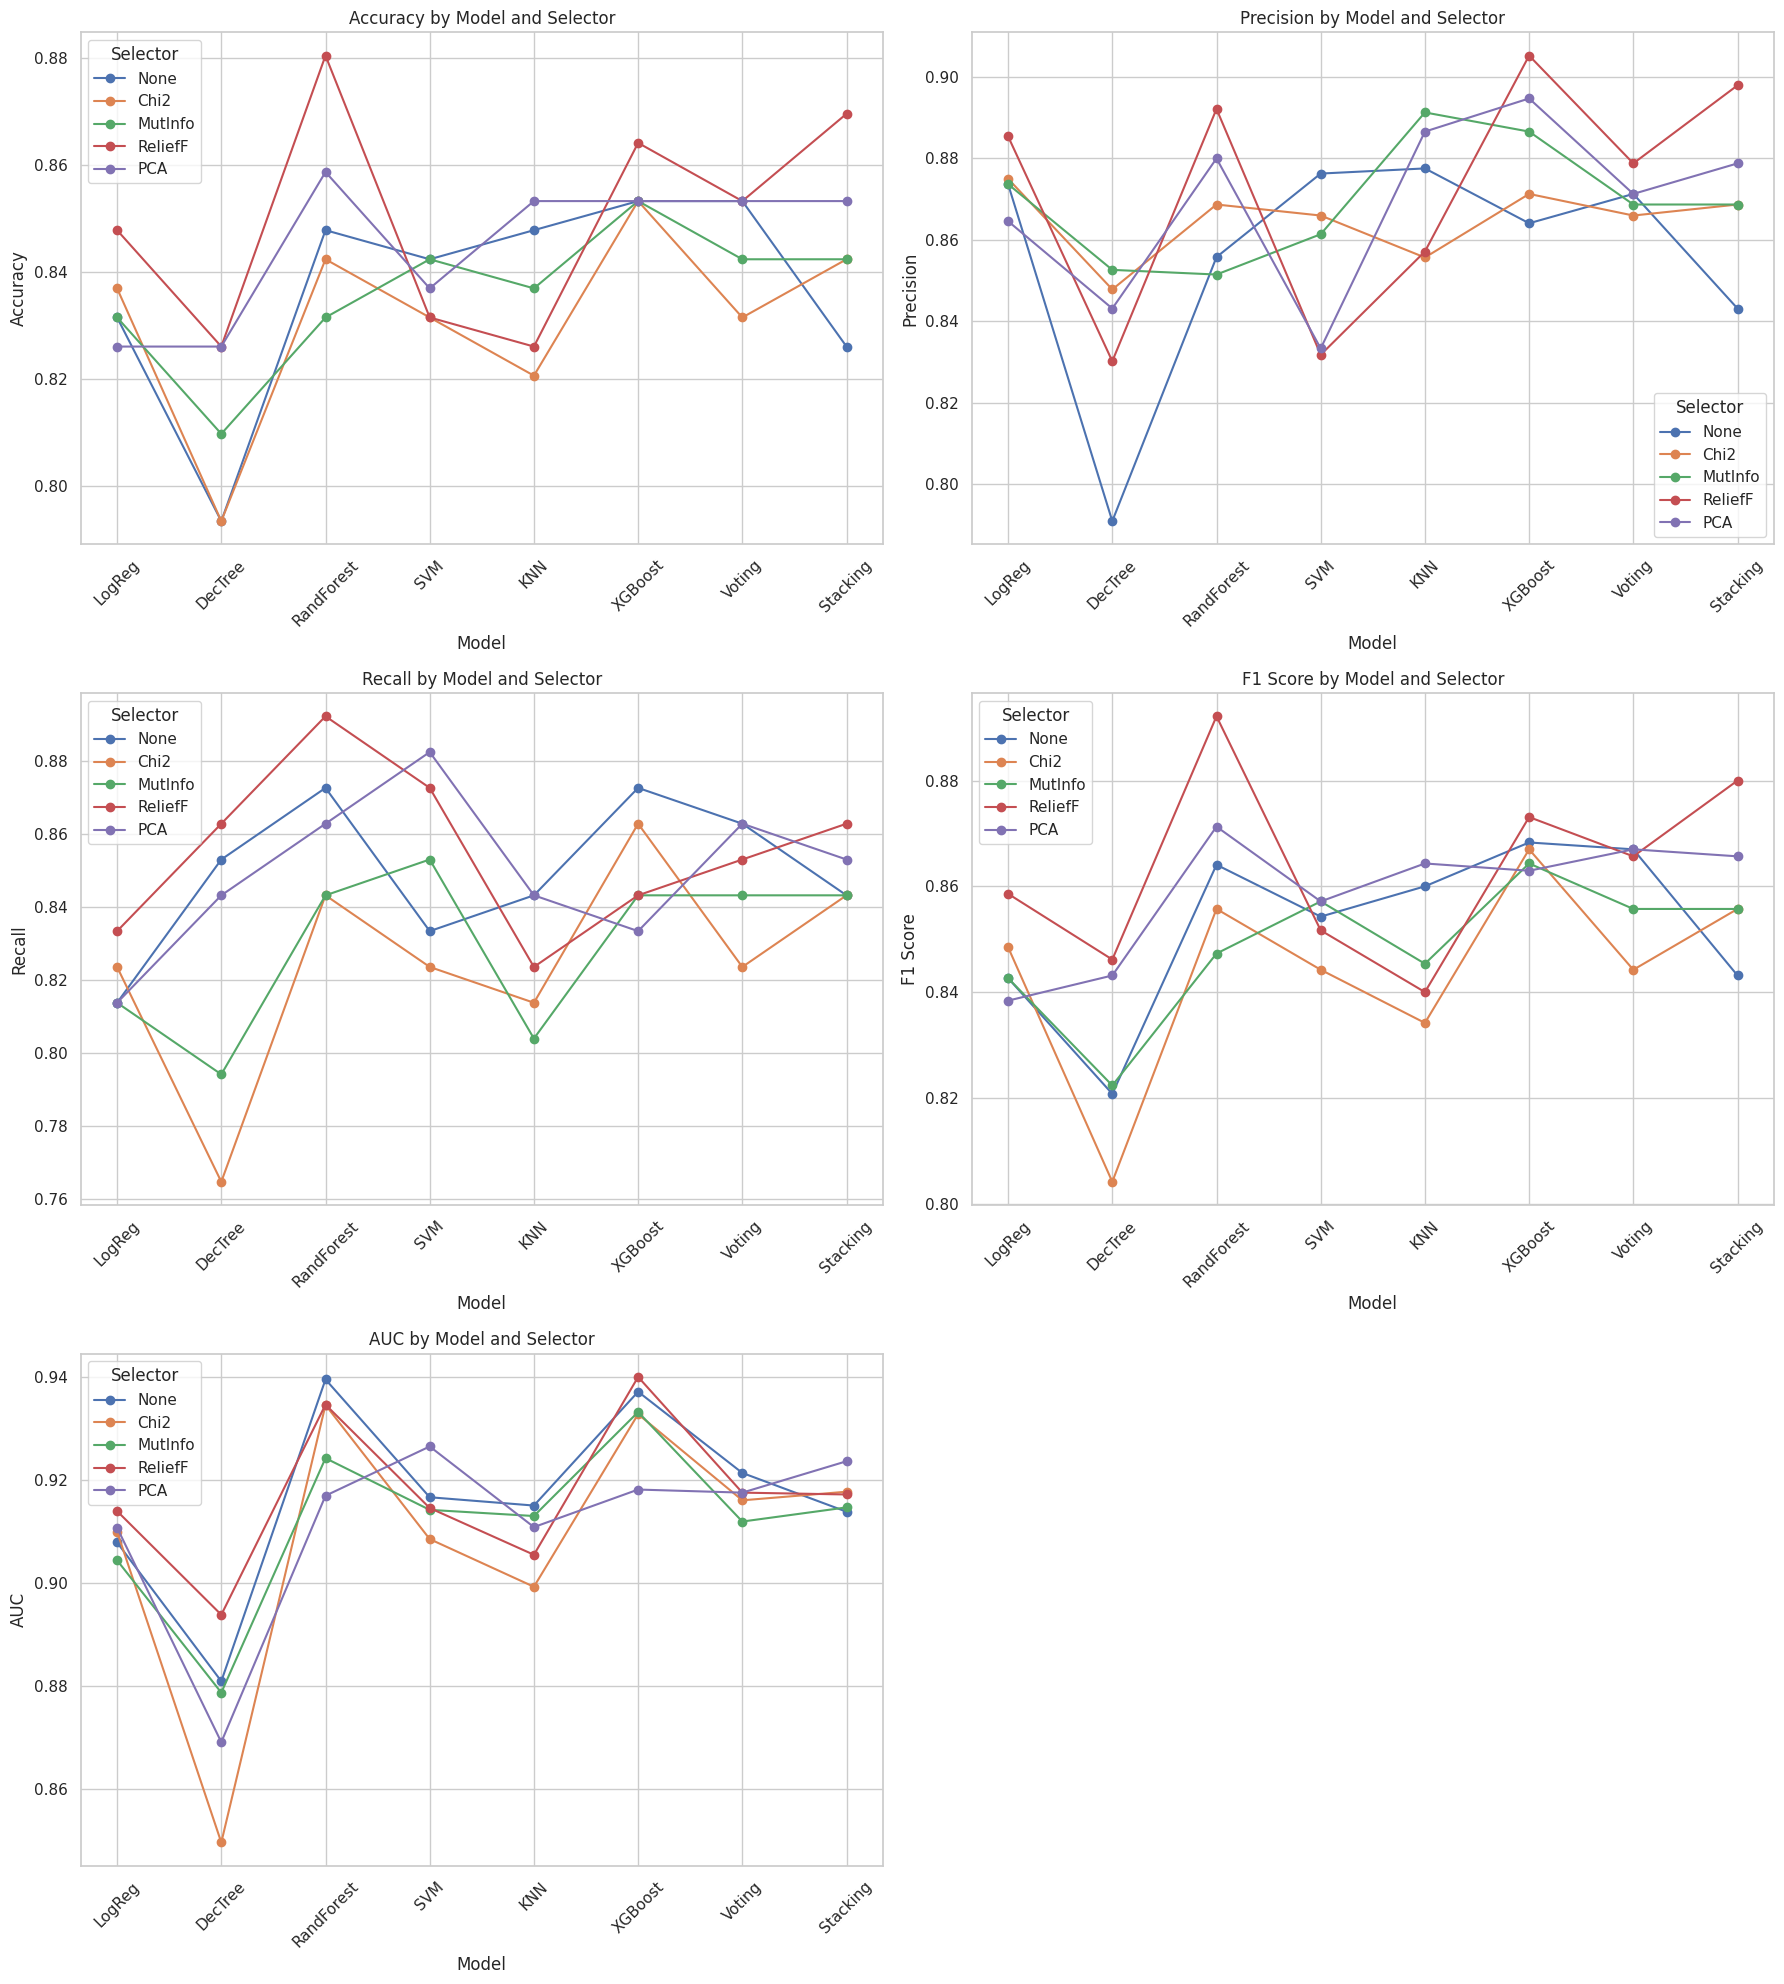

In [6]:
import matplotlib.pyplot as plt

# Metrics to visualize
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"]

# List of unique models and selectors for ordering
models = df_results['Model'].unique()
selectors = df_results['Selector'].unique()

plt.figure(figsize=(18, 20))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    
    for sel in selectors:
        subset = df_results[df_results['Selector'] == sel]
        # Ensure consistent order by model
        subset = subset.set_index('Model').reindex(models)
        plt.plot(models, subset[metric], marker='o', label=sel)
    
    plt.title(f"{metric} by Model and Selector")
    plt.xlabel("Model")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Selector")

plt.tight_layout()
plt.show()